In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

In [23]:
df = pd.read_csv('DATA_WITH_SALES.csv', sep=';')
df = df[df.Stock > 0]
df.rename(columns={'Stock': 'Demand'}, inplace=True)

df.head(n=5)

,Store_ID,SKU_ID,Date,Sales,Demand,Regular_Price
0,1100,114,01JAN2019,0.0,1.0,51.0
1,1078,114,01JAN2019,0.0,2.0,51.0
2,1191,114,01JAN2019,0.0,2.0,53.0
3,2230,114,01JAN2019,0.0,1.0,40.0
4,1120,114,01JAN2019,0.0,1.0,53.0


In [24]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [25]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,98692,1098,90
1,97140,1090,90
2,97140,1087,90
3,97140,1086,90
4,97140,1085,90
5,97140,1084,90
6,97140,1083,90
7,97140,1081,90
8,97128,2834,90
9,97128,2711,90


In [26]:
popular_pairs.head(n=50000).tail(n=1)

,SKU_ID,Store_ID,counts
49999,13156,1086,90


In [27]:
pairs_for_experiment = []
num_of_pairs = 50000
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment.append((r['SKU_ID'], r['Store_ID']))

In [28]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [29]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [30]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [31]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [32]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [33]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue = [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.Demand.sum() / data.shape[0])
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue
    })

In [34]:
trained_data = GeneratePEDModels(df)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
C:\Users\User\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [176]:
trained_data.to_csv('train_data.csv')

In [177]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]

In [178]:
df_train.head()

,SKU,Store,Elasticity,Qty,P_value
3,97140,1086,-2.682751,3.911111,5.429218e-04
4,97140,1085,-5.769920,5.633333,3.125485e-41
7,97140,1081,-6.747417,7.255556,3.004648e-03
8,97128,2834,-2.938277,398.411111,4.927807e-04
11,97128,1954,-8.201317,1.322222,2.705127e-33


In [179]:
product_info = pd.read_excel('PRODUCT_INF.xlsx')
product_info.rename(columns={'Code_AP': 'SKU'}, inplace=True)

In [180]:
product_info[product_info.SKU == 97140]

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
192058,Контролок таб.п.кш.о.20мг №14,97140,2003,2047,2099,2532,994,Лекарственные и профилактические средства,Пищеварительный тракт,Для улучшения пищеварения,Ингибиторы протонной помпы,Пантопразол


In [181]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId']]

In [182]:
product_info.head()

,SKU,ClassId,CategoryId,ClusterId
0,9999999,-5,-2,-1
1,122139,-5,-2,-1
2,122140,-5,-2,-1
3,122141,-5,-2,-1
4,122142,-5,-2,-1


In [183]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')

In [184]:
df_sku.isna().sum()

SKU           0
Store         0
Elasticity    0
Qty           0
P_value       0
ClassId       0
CategoryId    0
ClusterId     0
dtype: int64

In [185]:
df_sku.head()

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId
3,97140,1086,-2.682751,3.911111,5.429218e-04,2003,2532,994
4,97140,1085,-5.769920,5.633333,3.125485e-41,2003,2532,994
7,97140,1081,-6.747417,7.255556,3.004648e-03,2003,2532,994
8,97128,2834,-2.938277,398.411111,4.927807e-04,2003,2711,39
11,97128,1954,-8.201317,1.322222,2.705127e-33,2003,2711,39


In [186]:
store_info = pd.read_excel('LOCATION_INF.xlsx')
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

In [187]:
import string
store_info['TradePointName'] = store_info['TradePointName'].str.upper()
store_info['TradePointName'] = store_info['TradePointName'].str.split(' ').str[0]
store_info['TradePointName'] = store_info['TradePointName'].replace(r'[{}]'.format(string.punctuation), '', regex=True)
set(store_info['TradePointName'])

{'ВО', 'ВОЛОГДА', 'ИНТЕРНЕТМАГАЗИН', 'ЛО', 'СПБ', 'ЧЕРЕПОВЕЦ', 'ШУШАРЫ'}

In [188]:
df_sku = df_sku.join(store_info.set_index('Store'), on='Store')

In [189]:
df_sku

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId,TradePointCode,TradePointName,OpenDate,CloseDate,BrandName,BrandGroupId,Brands_GUID,BE_Id,BE_Name,BE_GUID
3,97140,1086,-2.682751,3.911111,5.429218e-04,2003,2532,994,А01085,СПБ,2008-09-28,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
4,97140,1085,-5.769920,5.633333,3.125485e-41,2003,2532,994,А01084,СПБ,2010-09-21,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
7,97140,1081,-6.747417,7.255556,3.004648e-03,2003,2532,994,А01080,СПБ,2008-06-16,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
8,97128,2834,-2.938277,398.411111,4.927807e-04,2003,2711,39,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
11,97128,1954,-8.201317,1.322222,2.705127e-33,2003,2711,39,А01953,ВО,2014-09-16,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49960,13172,1768,-3.749650,4.788889,1.376729e-81,2003,2561,28,А01767,СПБ,2001-01-01,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49973,13156,1118,-1.819591,26.166667,2.276186e-02,2003,2489,467,А01117,СПБ,2016-06-08,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49987,13154,1953,-4.151737,4.766667,6.777473e-55,2003,2489,467,А01952,ЧЕРЕПОВЕЦ,2014-07-30,2020-05-29,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49988,13154,1954,-5.134763,4.855556,4.737847e-28,2003,2489,467,А01953,ВО,2014-09-16,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8


In [190]:
df_sku.isna().sum()

SKU               0
Store             0
Elasticity        0
Qty               0
P_value           0
ClassId           0
CategoryId        0
ClusterId         0
TradePointCode    0
TradePointName    0
OpenDate          0
CloseDate         0
BrandName         0
BrandGroupId      0
Brands_GUID       0
BE_Id             0
BE_Name           0
BE_GUID           0
dtype: int64

In [191]:
df_sku = df_sku.rename(columns = {'TradePointName': 'Region'})

In [192]:
store_info.BrandGroupId.value_counts()

3    184
Name: BrandGroupId, dtype: int64

In [193]:
store_info.BE_Id.value_counts()

25    184
Name: BE_Id, dtype: int64

In [194]:
store_info.Brands_GUID.value_counts()

E378FD87-0BB5-E984-11E8-54EE74216F5D    184
Name: Brands_GUID, dtype: int64

In [195]:
import time
df_sku['OpenDate'] = pd.to_datetime(df_sku.OpenDate)
#cur_date = time.mktime(time.strptime('01/01/2019', "%d/%m/%Y"))
df_sku['OpenDate'] = df_sku['OpenDate'].rsub(pd.Timestamp('today')).dt.days
df_sku.rename(columns={'OpenDate' : 'DaysOpen'}, inplace = True)


,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId,TradePointCode,Region,DaysOpen,CloseDate,BrandName,BrandGroupId,Brands_GUID,BE_Id,BE_Name,BE_GUID
3,97140,1086,-2.682751,3.911111,5.429218e-04,2003,2532,994,А01085,СПБ,4574,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
4,97140,1085,-5.769920,5.633333,3.125485e-41,2003,2532,994,А01084,СПБ,3851,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
7,97140,1081,-6.747417,7.255556,3.004648e-03,2003,2532,994,А01080,СПБ,4678,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
8,97128,2834,-2.938277,398.411111,4.927807e-04,2003,2711,39,А02829,ИНТЕРНЕТМАГАЗИН,827,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
11,97128,1954,-8.201317,1.322222,2.705127e-33,2003,2711,39,А01953,ВО,2395,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49960,13172,1768,-3.749650,4.788889,1.376729e-81,2003,2561,28,А01767,СПБ,7401,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49973,13156,1118,-1.819591,26.166667,2.276186e-02,2003,2489,467,А01117,СПБ,1764,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49987,13154,1953,-4.151737,4.766667,6.777473e-55,2003,2489,467,А01952,ЧЕРЕПОВЕЦ,2443,2020-05-29,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
49988,13154,1954,-5.134763,4.855556,4.737847e-28,2003,2489,467,А01953,ВО,2395,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8


In [200]:
df_sku.head(n=1)

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId,TradePointCode,Region,DaysOpen,CloseDate,BrandName,BrandGroupId,Brands_GUID,BE_Id,BE_Name,BE_GUID
3,97140,1086,-2.682751,3.911111,0.000543,2003,2532,994,А01085,СПБ,4574,2100-01-01,Озерки,3,E378FD87-0BB5-E984-11E8-54EE74216F5D,25,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8


In [202]:
X = df_sku[['SKU', 'Store', 'ClassId', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen']]
one_hot = pd.get_dummies(X['Region'])
# Drop column B as it is now encoded
X = X.drop('Region',axis = 1)
# Join the encoded df
X = X.join(one_hot)
print(X)
X = X.to_numpy()  
y = df_sku['Elasticity'].to_numpy()

         SKU  Store  ClassId  CategoryId  ClusterId  DaysOpen  ВО  ВОЛОГДА  \
3      97140   1086     2003        2532        994      4574   0        0   
4      97140   1085     2003        2532        994      3851   0        0   
7      97140   1081     2003        2532        994      4678   0        0   
8      97128   2834     2003        2711         39       827   0        0   
11     97128   1954     2003        2711         39      2395   1        0   
...      ...    ...      ...         ...        ...       ...  ..      ...   
49960  13172   1768     2003        2561         28      7401   0        0   
49973  13156   1118     2003        2489        467      1764   0        0   
49987  13154   1953     2003        2489        467      2443   0        0   
49988  13154   1954     2003        2489        467      2395   1        0   
49992  13156   1077     2003        2489        467      5789   0        0   

       ИНТЕРНЕТМАГАЗИН  ЛО  СПБ  ЧЕРЕПОВЕЦ  ШУШАРЫ  
3         

In [203]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [207]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor().fit(X_train, y_train)

In [208]:
mean_squared_error(y_test, reg.predict(X_test))

6.055363941308769

Text(0, 0.5, 'Predictions')

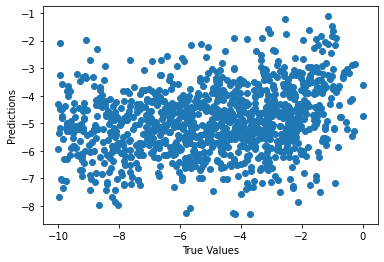

In [209]:
plt.scatter(y_test, reg.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

6.055363941308769

# RandomForest

## подбор гипер параметров

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [5, 6, 7, 8],
    'n_estimators': [100,150,200,250]
}
# Create a based model

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#{'bootstrap': True,
# 'max_depth': 80,
# 'max_features': 3,
# 'min_samples_leaf': 5,
# 'min_samples_split': 12,
# 'n_estimators': 100}
best_grid = grid_search.best_estimator_
mean_squared_error(y_test, grid_search.predict(X_test))

Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.0s


In [ ]:
plt.scatter(y_test, grid_search.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

## MSE, Графики на кросс-вале

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.9min finished


MSE : 1
5.404326833662495
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.8min finished


MSE : 2
5.756727634121578
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


MSE : 3
5.668616190767289
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


MSE : 4
6.755755977431197
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


MSE : 5
6.225282240080784
Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


MSE : 6
5.943240644408223


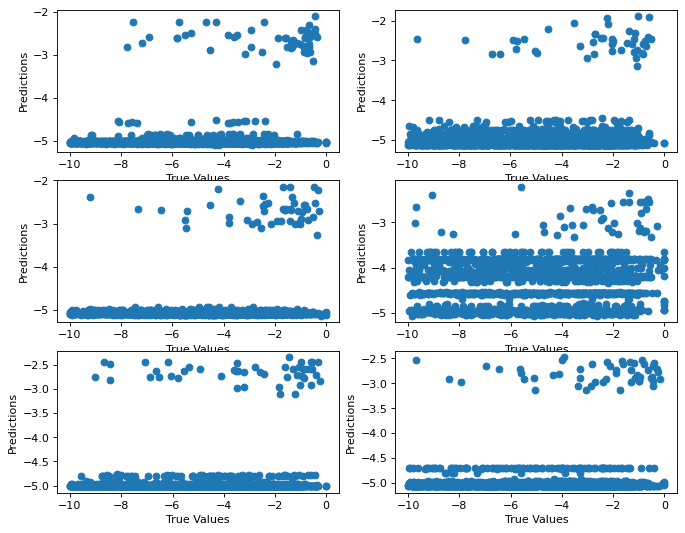

In [271]:
kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    grid_search.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, grid_search.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, grid_search.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()


# Catboost

## Обучимся на всем сете ошибка кросс-вал

In [259]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
# Create a based model
cb = CatBoostRegressor(verbose=False)
# Instantiate the grid search model

cb.fit(X, y)
cv_scores = cross_val_score(cb, X, y, cv=5, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))


Cross validation scores:
	 -2.4653
	-2.4339
	-2.4385
	-2.6903
	-2.5174
Mean CV MSE = 2.5091


## Сделаем честный кросс-вал

MSE : 1
5.703520172030113
MSE : 2
6.034692433456428
MSE : 3
5.919997109820166
MSE : 4
6.905400674321879
MSE : 5
6.876355704705507
MSE : 6
6.373823168220241


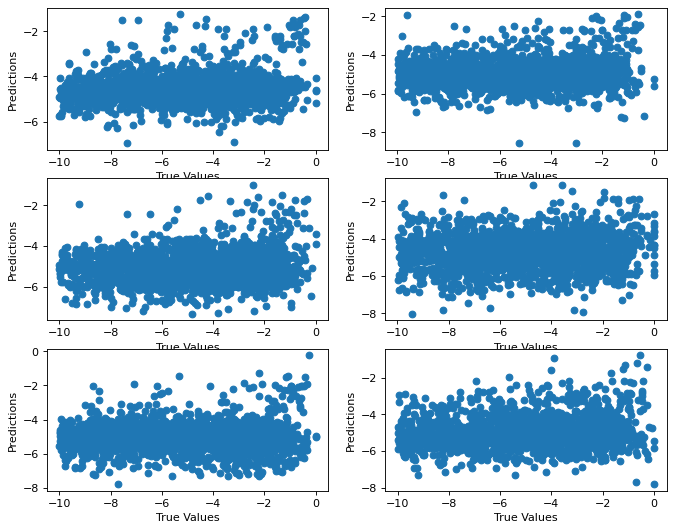

In [248]:
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
# Create a based model
cb = CatBoostRegressor(verbose=False)
# Instantiate the grid search model

kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    cb.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, cb.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, cb.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()


# XGBoost

## Подбор гиперпараметров

In [267]:
from xgboost import XGBRegressor


xgb = XGBRegressor(nthread=-1)

param_grid = {
    'max_depth': [2, 3, 4],
    'min_child_weight':[1,2,3],
    'gamma':[i/10.0 for i in range(2,5)],
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#{'bootstrap': True,
# 'max_depth': 80,
# 'max_features': 3,
# 'min_samples_leaf': 5,
# 'min_samples_split': 12,
# 'n_estimators': 100}
best_grid = grid_search.best_estimator_
mean_squared_error(y_test, grid_search.predict(X_test))


Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   14.2s finished


{'gamma': 0.2, 'max_depth': 2, 'min_child_weight': 1}


6.045960294265376

## MSE, Графики cross-val

Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   20.1s finished


MSE : 1
5.550754248044458
Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   20.3s finished


MSE : 2
5.840384783463487
Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   20.9s finished


MSE : 3
5.828972361297329
Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   19.4s finished


MSE : 4
6.856771224889763
Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   19.4s finished


MSE : 5
6.348919321529752
Fitting 6 folds for each of 27 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   21.7s finished


MSE : 6
6.045960294265376


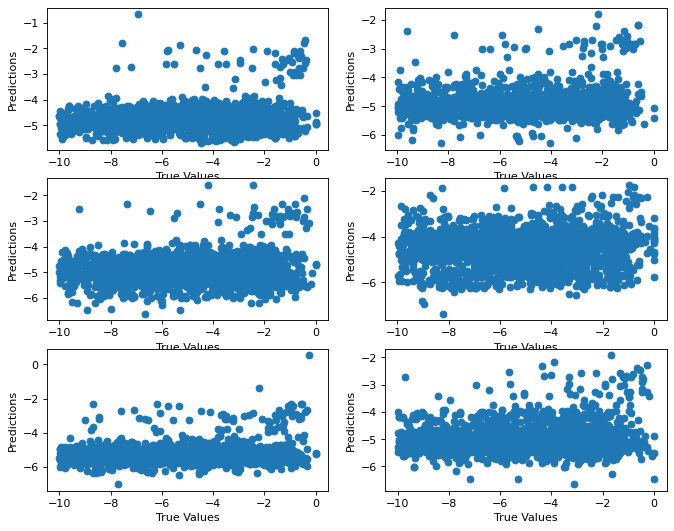

In [268]:

kf = KFold(n_splits=6)
kf.get_n_splits(X)


plt.figure(figsize=(10,8), dpi= 80)

i = 0
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_cross, X_test = X[train_index], X[test_index]
    y_cross, y_test = y[train_index], y[test_index]
    grid_search.fit(X_cross, y_cross)
    print("MSE :", i+1)
    print(mean_squared_error(y_test, grid_search.predict(X_test)))
    plt.subplot(321 + i)
    plt.scatter(y_test, grid_search.predict(X_test))
    i += 1
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

plt.show()